In [19]:
import xarray as xr
import pandas as pd
import numpy as np
from itertools import compress

In [20]:
#load data with xarray
file_path = r"d:\klein\datasets_DEcoImpact\conv_schism_raw_2.nc"
xr_file = xr.open_dataset(file_path)
print(xr_file)

<xarray.Dataset> Size: 6GB
Dimensions:                  (nSCHISM_hgrid_face: 1019883,
                              nMaxSCHISM_hgrid_face_nodes: 4,
                              nSCHISM_hgrid_node: 515582, time: 24,
                              nSCHISM_vgrid_layers: 21)
Coordinates:
  * time                     (time) datetime64[ns] 192B 2017-01-03T01:00:00 ....
Dimensions without coordinates: nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes,
                                nSCHISM_hgrid_node, nSCHISM_vgrid_layers
Data variables: (12/14)
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) int32 16MB ...
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 4MB ...
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 4MB ...
    depth                    (nSCHISM_hgrid_node) float32 2MB ...
    dryFlagElement           (time, nSCHISM_hgrid_face) float32 98MB ...
    dryFlagNode              (time, nSCHISM_hgrid_node) flo

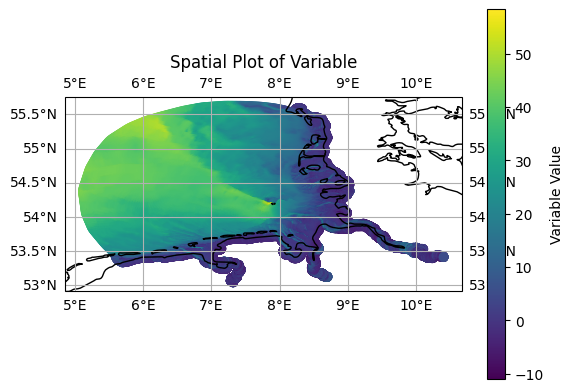

In [21]:
#plot grid
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

var = xr_file['depth']
lat = xr_file['SCHISM_hgrid_node_y']
lon = xr_file['SCHISM_hgrid_node_x']

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
scatter = ax.scatter(lon, lat, c=var, cmap='viridis', marker='o', transform=ccrs.PlateCarree())
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Variable Value')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('Spatial Plot of Variable')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [22]:
def row_in_list(row, check_set):
    '''
    Function to asses if all values of row are in list, ignoring nan's
    '''
    row_non_nan = row.dropna().tolist()
    return all(item in check_set for item in row_non_nan)

#Subset on time to reduce size
sub_file = xr_file.sel(time = slice("2017-01-03 00:00:00", "2017-01-03 04:00:00"))
time_attrs = sub_file["time"].attrs
#time_attrs["_FillValue"] = False
sub_file["time"] = sub_file["time"].assign_attrs(time_attrs)


#Subset on bounding box
bool_nodes_needed = (sub_file['SCHISM_hgrid_node_y'] >= 54) & (sub_file['SCHISM_hgrid_node_y'] <= 54.08) &\
    (sub_file['SCHISM_hgrid_node_x'] >= 8.9)  & (sub_file['SCHISM_hgrid_node_x'] <= 9) 
#index_nodes_needed = [i for i, x in enumerate(bool_nodes_needed) if x]
index_nodes_needed = set(list(compress(range(len(bool_nodes_needed)), bool_nodes_needed)))

#create dataframe for selection
face_nodes_dataframe = pd.DataFrame(sub_file.SCHISM_hgrid_face_nodes.data)
face_nodes_dataframe = face_nodes_dataframe.replace(-1,np.NaN)

#Get the faces that are needed
faces_needed = face_nodes_dataframe.apply(lambda row : row_in_list(row,index_nodes_needed), axis = 1)
faces_needed = list(faces_needed[faces_needed==True].index.values)

#filter on nodes from dataset data
sub_file = sub_file.sel(nSCHISM_hgrid_node = xr_file.nSCHISM_hgrid_node.isin(list(index_nodes_needed)))

#filter on faces from dataset data
sub_file = sub_file.sel(nSCHISM_hgrid_face = xr_file.nSCHISM_hgrid_face.isin(faces_needed))

#renumber nodes needed
ar = sub_file.SCHISM_hgrid_face_nodes.data
k = np.array([k for k in sorted(list(index_nodes_needed))]) 
v = np.array(range(0,len(index_nodes_needed)))

#replace
copy_data = sub_file.SCHISM_hgrid_face_nodes.data.copy()
check_copy_data = sub_file.SCHISM_hgrid_face_nodes.data.copy()
for key, value in zip(k,v):
    copy_data[sub_file.SCHISM_hgrid_face_nodes.data == key] = value

#reset to non-existing cells to -1
copy_data[np.isnan(copy_data)] = -1

#replace with the corrected data
sub_file.SCHISM_hgrid_face_nodes.data = copy_data

#Check
print(sub_file)


<xarray.Dataset> Size: 2MB
Dimensions:                  (nSCHISM_hgrid_face: 1485,
                              nMaxSCHISM_hgrid_face_nodes: 4,
                              nSCHISM_hgrid_node: 849, time: 4,
                              nSCHISM_vgrid_layers: 21)
Coordinates:
  * time                     (time) datetime64[ns] 32B 2017-01-03T01:00:00 .....
Dimensions without coordinates: nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes,
                                nSCHISM_hgrid_node, nSCHISM_vgrid_layers
Data variables: (12/14)
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) int32 24kB ...
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 7kB 8.981 ... 8.902
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 7kB 54.07 ... 54.03
    depth                    (nSCHISM_hgrid_node) float32 3kB -4.943 ... -6.206
    dryFlagElement           (time, nSCHISM_hgrid_face) float32 24kB ...
    dryFlagNode             

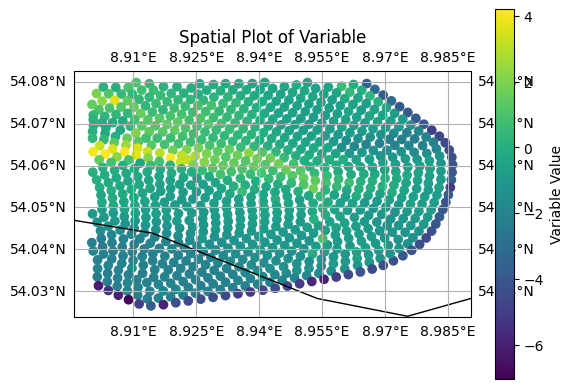

In [23]:
#plot grid
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

var = sub_file['depth']
lat = sub_file['SCHISM_hgrid_node_y']
lon = sub_file['SCHISM_hgrid_node_x']

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
scatter = ax.scatter(lon, lat, c=var, cmap='viridis', marker='o', transform=ccrs.PlateCarree())
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Variable Value')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('Spatial Plot of Variable')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()

In [24]:
#write to file example
sub_file.to_netcdf("rawdata/schism_output_example.nc")